# Analyzing Twitter data

## Part 1 - The network of retweets

In [2]:
import os
import networkx as nx
import community
import numpy as np
import pandas as pd
import re
import random
from tqdm import tqdm_notebook as tqdm
import math
import operator

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
plt.style.use('seaborn-deep')

data_path = '../data/twitter'

In [7]:
twitter_handles = pd.read_csv(os.path.join(data_path, 'H115_tw.csv'))

In [10]:
# Find edges
retweet_regex = r'^RT @(?P<name>\S+):'
retweets = {}
for name in tqdm(twitter_handles.tw_name):
    with open(os.path.join(data_path, 'tweets', name), 'r', encoding='utf8') as f:
        tweets = f.read().split('\n')
    retweets[name] = []
    for tweet in tweets:
        m = re.search(retweet_regex, tweet)
        if m and m.group('name'):
            retweets[name].append(m.group('name'))   

In [11]:
G = nx.DiGraph()
nodes = [(twitter_handles['tw_name'].iloc[i], { 'Party': twitter_handles['Party'].iloc[i]}) 
     for i in range(len(twitter_handles.tw_name))]
G.add_nodes_from(nodes)

In [14]:
for name, others in retweets.items():
    edges = []
    connections = set(x for x in set(others) if x in set(twitter_handles.tw_name))
    for connection in connections:
        if connection == name:
            continue
        weight = others.count(connection)
        edges.append((name, connection, weight))
    G.add_weighted_edges_from(edges)

### Exercise 3 - Visualize the network

First we set the size equal to the nodes total degree

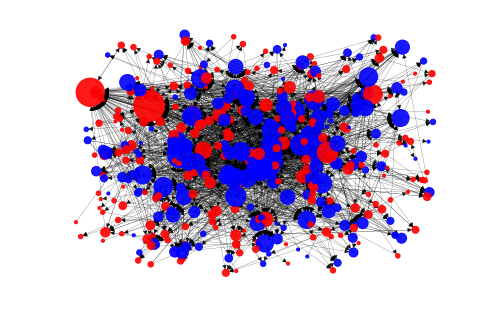

In [41]:
node_color = ['red' if attr['Party'] == 'Republican' else 'blue' for _, attr in nodes]
node_size = [G.degree(n) * 10 for n, _ in nodes]
nx.draw(G, pos=nx.spring_layout(G, k=0.15, iterations=2), 
        node_color=node_color, node_size=node_size,
        width=0.2, alpha=0.9)

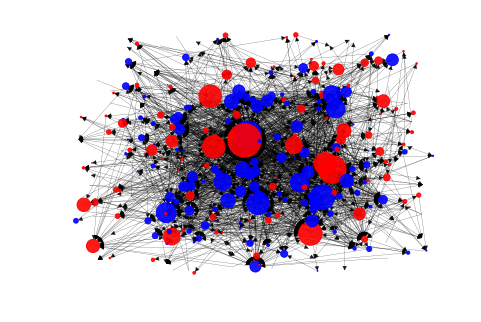

In [65]:
betweenness_nodes = nx.betweenness_centrality(G)
node_size = [10000 * betweenness_nodes[x] for x in G.nodes()]
nx.draw(G, pos=nx.spring_layout(G, k=0.15, iterations=2), 
        node_color=node_color, node_size=node_size,
        width=0.2, alpha=0.9)

When visualizing the network based on the betweenness centrality, it seems like there is fewer bigger nodes, compared to when we only look at the degrees of the nodes.

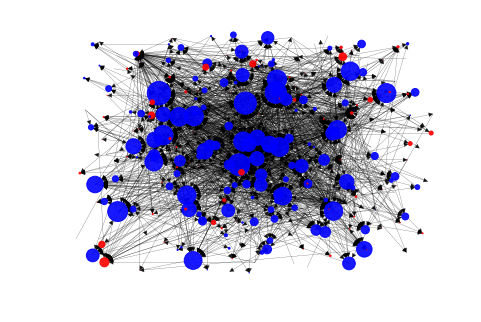

In [62]:
eigenvector_nodes = nx.eigenvector_centrality(G)
node_size = [2000 * eigenvector_nodes[x] for x in G.nodes()]
nx.draw(G, pos=nx.spring_layout(G, k=0.15, iterations=2), 
        node_color=node_color, node_size=node_size,
        width=0.2, alpha=0.9)

Very interestingly the democratic politicians seem to be weight much larger by the eigenvector centrality. 

In [87]:
democratic_nodes = [x for x in G.nodes() if G.node[x]['Party'] == 'Democratic']
republican_nodes = [x for x in G.nodes() if G.node[x]['Party'] == 'Republican']
for nodes in [democratic_nodes, republican_nodes]:
    print('Top five ' + party + ' by degree: ' + 
        ', '.join(sorted(nodes, key=lambda node: G.degree(node))[:5]))
    print('Top five ' + party + ' by eigenvector centrality: ' + 
        ', '.join(sorted(nodes, key=lambda node: eigenvector_nodes[node])[:5]))
    print('Top five ' + party + ' by betweenness: ' + 
        ', '.join(sorted(nodes, key=lambda node: betweenness_nodes[node])[:5]))
    print()

Top five Republican by degree: RepVisclosky, RepPeterDeFazio, RepRonKind, BradSherman, RepSusanDavis
Top five Republican by eigenvector centrality: RepJohnConyers, RepVisclosky, RepPeterDeFazio, louiseslaughter, RepJoseSerrano
Top five Republican by betweenness: RepJohnConyers, RepVisclosky, RepPeterDeFazio, louiseslaughter, RepJoseSerrano

Top five Republican by degree: RepJohnDuncanJr, RepFrankLucas, RepRobBishop, RepDevinNunes, RepKenMarchant
Top five Republican by eigenvector centrality: repdonyoung, RepHalRogers, RepChrisSmith, RepJoeBarton, RepJohnDuncanJr
Top five Republican by betweenness: repdonyoung, RepHalRogers, RepChrisSmith, RepJoeBarton, RepJohnDuncanJr



It can be seen that the eigenvector and betweenness centrality seem to find the same top candidates. 
Sorted by the degree does however create different results.

In [15]:
democratic_strength = sum([G.out_degree(x, weight='weight') for x in G.nodes()
                           if G.node[x]['Party'] == 'Democratic'])
republican_strength = sum([G.out_degree(x, weight='weight') for x in G.nodes()
                          if G.node[x]['Party'] == 'Republican'])

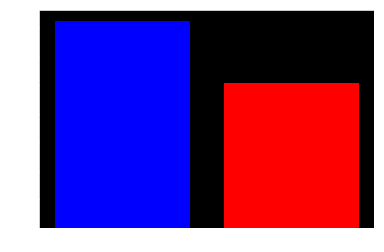

In [16]:
plt.bar(['Democratic', 'Republican'], [democratic_strength, republican_strength],
        color=['blue', 'red'])
plt.show()

In the chart above, it can be seen that members from the Democratic party are retweeting other members much more than members from the Republican party.

In [108]:
[x for x in republican_nodes
    if sum([G[other][x]['weight'] if other in democratic_nodes else -G[other][x]['weight']
        for other, _ in list(G.in_edges(x))]) > 0
]

['RepErikPaulsen',
 'SusanWBrooks',
 'RepRyanCostello',
 'RepJohnKatko',
 'RepMiaLove',
 'RepDavidYoung',
 'RepDanDonovan',
 'RepPaulMitchell']

These are all the repubilican members that have more retweets from the other party than from their own party.
After a quick look at these members wikipedia articles, there is no clear sign to why these members should be retweeted more by the opposed party.

The same can be done for the democratic party.

In [109]:
[x for x in democratic_nodes
    if sum([G[other][x]['weight'] if other in republican_nodes else -G[other][x]['weight']
        for other, _ in list(G.in_edges(x))]) > 0
]

['RepGeneGreen',
 'RepCuellar',
 'RepLipinski',
 'PeterWelch',
 'nikiinthehouse',
 'RepAndreCarson',
 'RepJohnDelaney',
 'RepDerekKilmer',
 'RepKathleenRice',
 'RepJoshG',
 'CongressmanRaja',
 'RepJackyRosen']

### Exercise 4 - Community detection

In [117]:
# %load ../week07/modularity.py
from networkx import Graph

def nodesWithGivenAttribute(G: Graph, attribute: str, value: str) -> dict:
    '''Find all the nodes from a given party

    @param G: networkx graph to look in
    @param attribute: used to group the nodes
    @param value: to filter all the nodes with
    @returns: A dictionary of nodes with their attributes
    '''
    return { x: G.node[x] for x in G.nodes() if G.node[x][attribute] == value }

def totalDegree(G: Graph, nodes: dict) -> int:
    '''Calculates the sum of all the degrees of the nodes

    @returns: The total degree of all the nodes
    '''
    return sum([G.degree(x) for x in nodes.keys()])

def totalNumberOfLinksWithinCommunity(G: Graph, nodes: dict) -> int:
    '''Find the total number of links within a community

    @param G: networkx graph to look in
    @param attribute: to group the community
    @param nodes: The community of nodes
    @returns: The number of links within a community
    '''
    return len([other
        for node in nodes
            for other in G.neighbors(node)
                if other in nodes
    ]) / 2

def modularityStats(G: Graph, nodes: dict) -> (float, float, float):
    '''Get the relevant constants for calculating modularity stats

    @param G: networkx graph to look in
    @param attribute: used to group the community
    @param party: to define the community

    @returns: (k_c, L_c, L)
    '''
    return (
        totalDegree(G, nodes)
        , totalNumberOfLinksWithinCommunity(G, nodes)
        , len(G.edges())
    )

def modularity(G: Graph, nodes: dict) -> float:
    '''Calculate the modularity of a community of nodes given the party

    @param G: networkx graph to look in
    @param party: The party that defines the community
    @returns: The modularity of the nodes in the graph with the given party
    '''
    k_c, L_c, L = modularityStats(G, nodes)

    M_c = L_c / L - (k_c / (2 * L))**2

    return M_c

In [120]:
partition = community.best_partition(G.to_undirected())
louvain_modularities = {}
for c in set(partition.values()):
    nodes = { node: {} for node in partition.keys() if partition[node] == c }
    louvain_modularities[c] = modularity(G, nodes)
    
print('Modularity given by the Louvain partition: {0:.5f}'
      .format(sum([m for _, m in louvain_modularities.items()])))

Modularity given by the Louvain partition: 0.05062


The modularity of this network based on the Twitter data shows a much lower modularity than the wikipedia network, meaning that the members are much more likely to retweet each other, than they are to occure on each other's wikipedia pages.

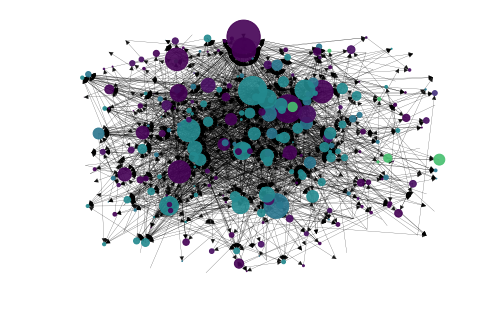

In [139]:
colors = [random.random() for i in range(len(louvain_modularities))]

node_color = [colors[value] for _, value in partition.items()]
nx.draw(G, pos=nx.spring_layout(G, k=0.15, iterations=2), 
        node_color=node_color, node_size=node_size,
        width=0.2, alpha=0.9)

The bigger nodes all seem to be in a few big comunities. 
There are a lot of communities, but most of them are quite small and consise small and not as active members.

In [166]:
confusion_matrix = {
    'Democratic': { i: 0 for i in set(partition.values()) }, 
    'Republican': { i: 0 for i in set(partition.values()) }
}
for party in confusion_matrix.keys():
    for name, c in partition.items():
        if G.node[name]['Party'] == party:
            confusion_matrix[party][c] += 1

In [167]:
for party in confusion_matrix.keys():
    print(party, end=': ')
    for value in confusion_matrix[party].values():
        print(value, end=', ')
    print()

Democratic: 7, 8, 53, 93, 1, 1, 4, 0, 5, 0, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 
Republican: 1, 142, 5, 0, 0, 0, 33, 1, 7, 1, 4, 0, 0, 0, 13, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 


From the confusion matrix, we can see that most of the communities consise of onle one member. 
At the same time, there is two large communities for the Democratic party, which has a few and no members from the Republican party.

For the Republicans, 142 of the members are in the same community, where only 8 members from the Democratic party also are. 
They also have one other group that stands out with 33 members, which seems to be the only relevant communities found.
This shows that the communities are heavely influenced by which party the members are in.

## Part 2 - What do Republican and Democratic members tweet about?

### Exercise 5 - TF-IDF of the republican and democratic tweets

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import string
import pickle
from wordcloud import WordCloud

In [4]:
def tokenize(text: str, names: set = []):
    sw = stopwords.words('english')
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens
                  if token not in names
                  and token not in sw
                  and not token.isdigit()
         ]
    return tokens

In [8]:
docs = {
    'Democratic': [],
    'Republican': []
}
for i in range(len(twitter_handles.tw_name)):
    name = twitter_handles['tw_name'].iloc[i]
    with open(os.path.join(data_path, 'tweets', name), 'r', encoding='utf8') as f:
        text = f.read()
    docs[twitter_handles['Party'].iloc[i]].append(text)

In [9]:
for key in docs.keys():
    docs[key] = '\n'.join(docs[key])

In [10]:
tokens = {}
for key in docs.keys():
    print('Tokenizing {0} document'.format(key))
    tokens[key] = tokenize(docs[key], set(twitter_handles.tw_name))

Tokenizing Democratic document
Tokenizing Republican document


First lets calculate the IDF.

In [11]:
def calculate_n_ts(tokens: list, documents: list) -> set:
    return {
        word: len([None for document in documents if word in document])
           for word in tqdm(set(tokens))
    }

def calculateIDF(nts: set, N: int, base=2) -> set:
    return { word: math.log(N / n_t, base)
        for word, n_t in tqdm(nts.items())     
    }

In [12]:
tokens_set = { key: set(value) for key, value in tokens.items() }

In [13]:
# This takes a very long time to execute
# n_ts = { party: calculate_n_ts(ts, tokens.values()) for party, ts in tokens.items() }
# with open('n_ts.data', 'wb') as f:
#     pickle.dump(n_ts, f)

In [14]:
with open('n_ts.data', 'rb') as f:
    n_ts = pickle.load(f)

In [15]:
IDF = {
    party: calculateIDF(n_ts[party], 2)
    for party, ts in tokens.items()
}

Now to calculate the TF-IDF

In [16]:
def calculateTF_IDF(tfs: set, IDFs: set) -> set:
    return {
        word: tf * IDFs[word]
        for word, tf in tfs.items()
    }

In [33]:
freq = { party: FreqDist(tokens) for party, tokens in tokens.items() }

In [34]:
TF_IDF = {
    party: calculateTF_IDF(freq[party], IDF[party])
    for party in tokens.keys()
}

Now to create a word cloud for the two parties.

In [35]:
clean_text = { party: ' '.join([t for t in tokens if not (t == 'rt' or t == 'amp')]) 
              for party, tokens in tokens.items() }

In [17]:
def drawWordCloud(text: str, title: str):
    wordcloud = WordCloud().generate(text)
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title(title)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    plt.show()

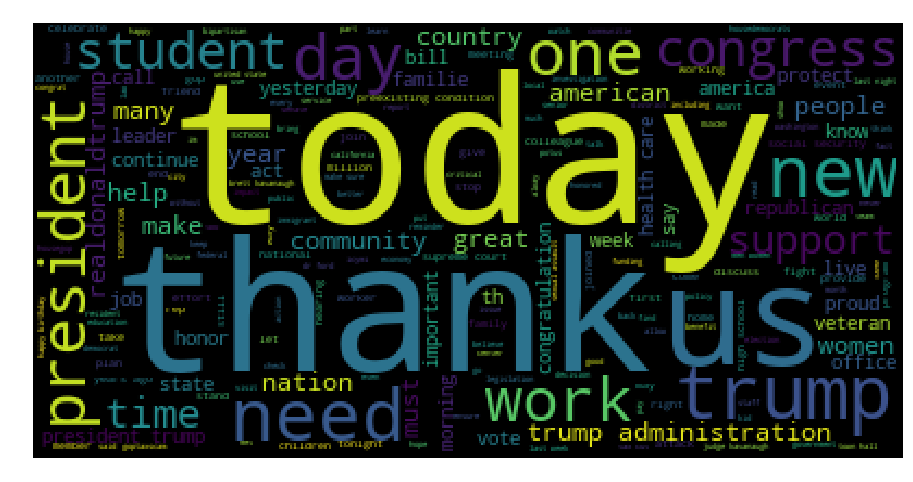

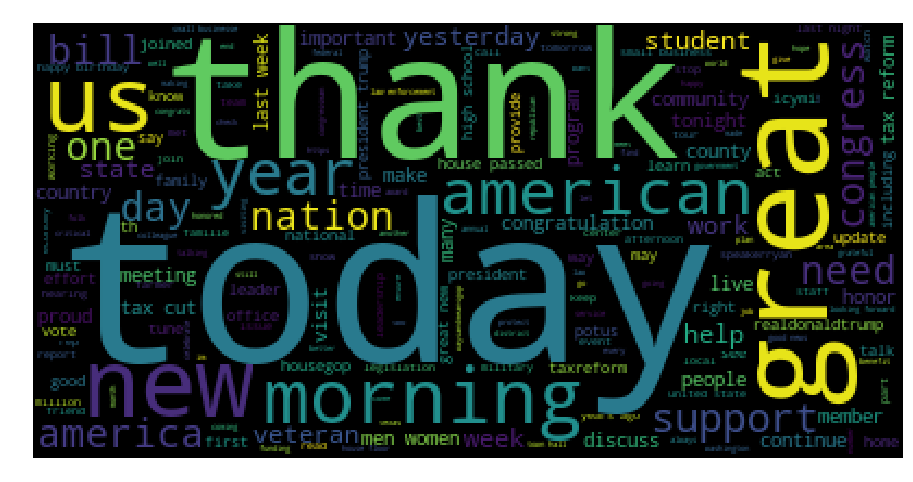

In [37]:
for party, text in clean_text.items():
    drawWordCloud(text, party)

These word clouds are very different from the wikipedia pages.
First of all, the Democratics tweet a lot about *trump* and the *trump administration*, which does not appear at all in the wikipedia cloud. 
Interestingly, only on the Democratic's image does Trump's twitter handle appear, meaning that they must engage more with him than Republicans.

*Today* is also a big word in both of the images, showing that the is a lot more focus on current items than there is on the wikipeida pages, which is not update as frequent.
*Thank* is also a very used word by both party's members.

The Republicans also use words like *american* and *veteran*, while the Democratic party members uses words like *people* and *student* more. 

## Part 3 - Sentiment analysis

The data set S1 was created by having people on Amazon Turk rank each word, based on how happy the word was to them.
Each word's rank is based on 50 user evaluations.

In [18]:
data_file = '../data/Data_Set_S1.csv'
df = pd.read_csv(data_file, delimiter='\t')
h_avg = { df['word'].iloc[i]: df['happiness_average'].iloc[i] for i in range(len(df.word))}

In [19]:
def calculate_sentiment(tokens: list, h_avg: dict) -> int:
    if len(tokens) == 0: 
        return 0
    frequency = FreqDist(tokens)
    return sum(h_avg[word] * frequency[word] for word in tokens if word in h_avg) / len(tokens)

In [20]:
tweets = { party: text.split('\n') for party, text in docs.items() }

In [21]:
sentiment = { 
    party: [calculate_sentiment(tokenize(tweet, []), h_avg) for tweet in tqdm(ts)] 
    for party, ts in tweets.items()
}

In [22]:
def plotDistribution(data: list, title: str):
    sorted_data = [x for x in sorted(data) if x < 10 and x != 0]
    fig, ax = plt.subplots(1, figsize=(16,8))
    ax.hist(sorted_data, bins=30)
    ax.set_title(title)
    fig.show()

c:\python37\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


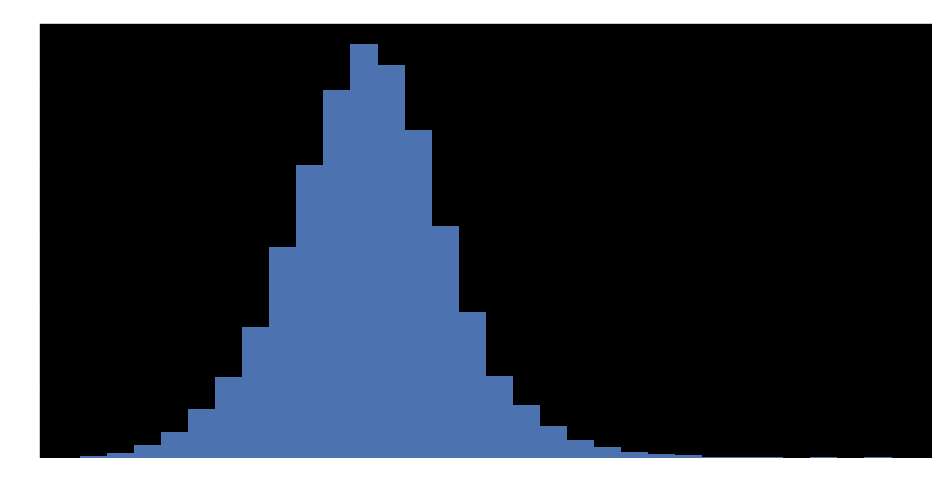

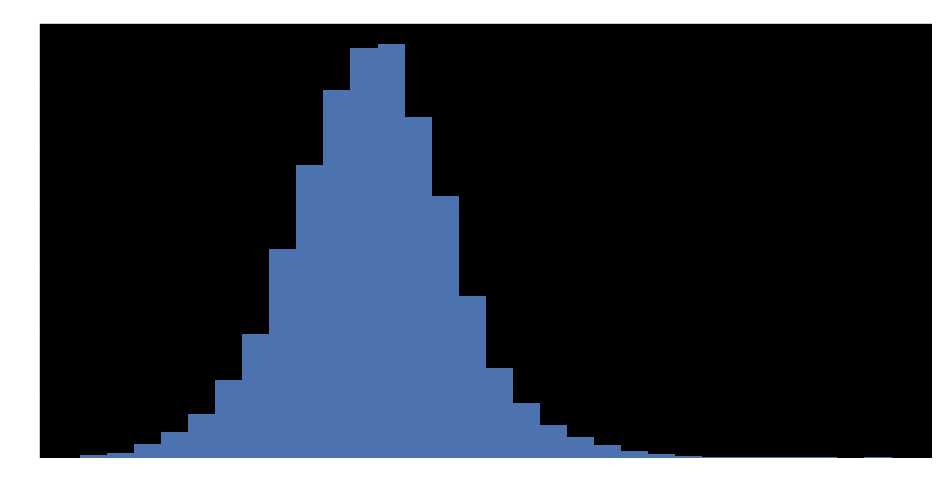

In [43]:
for party in sentiment.keys():
    plotDistribution(sentiment[party], party)

The two parties seem to tweet roughly the same distribution of happy tweets.
There is no significant difference between the two.

In [25]:
mean = { party: np.mean(sentiment[party]) for party in sentiment.keys() }
std = { party: np.std(sentiment[party]) for party in sentiment.keys() }

In [20]:
for party in sentiment.keys():
    print('Average and standard deviation of the tweets sentiment for {0}: m = {1:f} \tsigma = {2:f}'
         .format(party, mean[party], std[party]))

Average and standard deviation of the tweets sentiment for Democratic: m = 3.425776 	sigma = 1.394363
Average and standard deviation of the tweets sentiment for Republican: m = 3.523114 	sigma = 1.360199


Looking at the average and standard deviation of the two parties, it is again difficulte to tell the difference.

In [29]:
def analyseTweets(tweets: dict):
    tokens = {
        party: [t for t in tokenize('\n'.join(tweets)) 
                if not (t == 'rt' or t == 'amp' or t == '’')]   
        for party, tweets in tweets.items()
    }
    n_ts = {
        party: calculate_n_ts(ts, tokens.values())
        for party, ts in tokens.items()
    }
    IDF = {
        party: calculateIDF(n_ts, len(n_ts.keys()))
        for party, n_ts in n_ts.items()
    }
    freq = {
        party: FreqDist(tokens) for party, tokens in tokens.items()
    }
    TF_IDF = {
        party: calculateTF_IDF(freq[party], IDF)
        for party, IDF in IDF.items()
    }
    clean_text = { 
        party: ' '.join(tokens) 
        for party, tokens in tokens.items() 
    }  
    
    return (TF_IDF, clean_text)

In [30]:
negative_tweets = {
    party: 
        [tweet for i, tweet in enumerate(ts) 
             if sentiment[party][i] < mean[party] - 2*std[party] 
             and sentiment[party][i] != 0
        ]
    for party, ts in tweets.items()
}
negative_TF_IDF, negative_clean_text = analyseTweets(negative_tweets)

In [31]:
for party, TF_IDF in negative_TF_IDF.items():
    print('Top five TF-IDF for {0}: {1}'
          .format(party, sorted(TF_IDF, key=lambda x: TF_IDF[x], reverse=True)[:5]))

Top five TF-IDF for Democratic: ['congressman', 'hfacdemocrats', 'icymi', 'rm', 'repeliotengel']
Top five TF-IDF for Republican: ['unemployment', 'r…', 'opioid', 'congressman', '→']


In [42]:
negative_clean_text = { 
    party: ' '.join([t for t in tokens if not (t == 'rt' or t == 'amp')]) 
    for party, tokens in negative_tokens.items() 
}

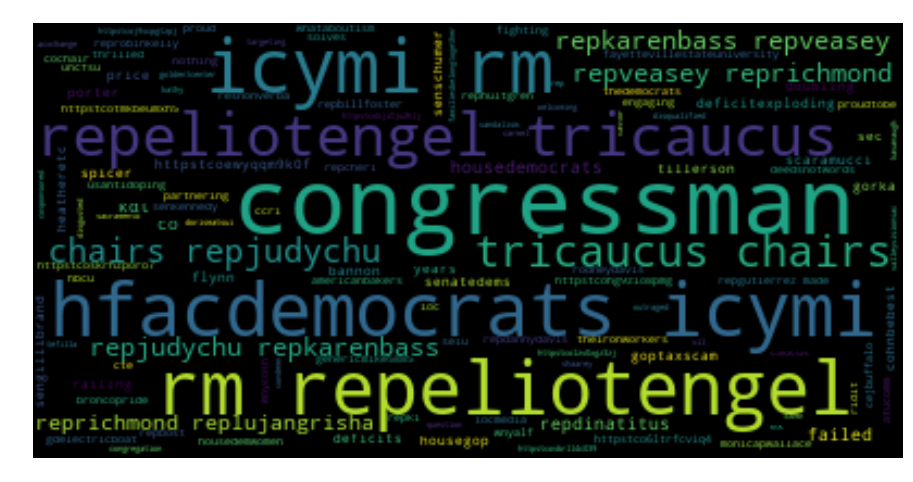

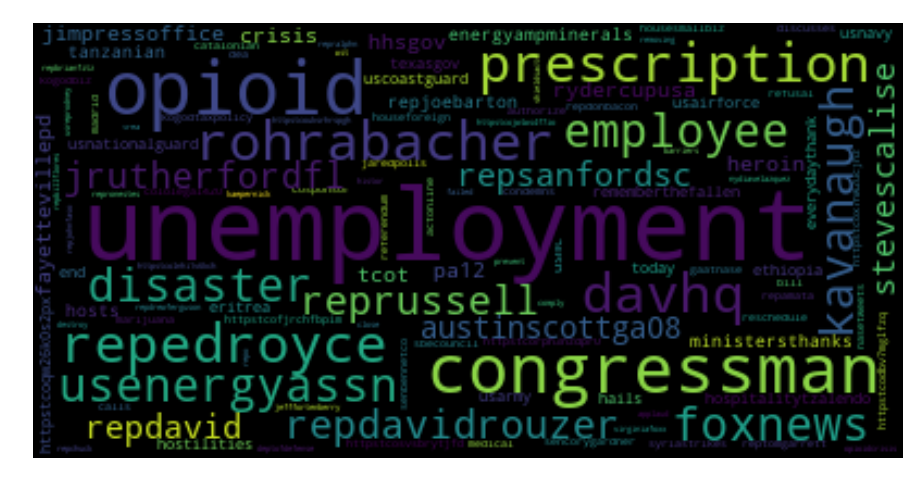

In [49]:
for party, text in negative_clean_text.items():
    drawWordCloud(text, party)

Some of the most used words by the Democratic members in their negative tweets are Twitter handles and the word *congressman*, which points towards that they are targeting their anger againts individual people or organizations.

*Unemployment* is a big word associated with negative tweets for the Republicans. Republicans also have quite a few twitter handles along with *foxnews*, which must mean that Republican congress members mostly watches Fox news and gets riled up about their news.

Now lets analyze the positive tweets.

In [32]:
positive_tweets = {
    party: 
        [tweet for i, tweet in enumerate(tweets) 
             if sentiment[party][i] > mean[party] + 2*std[party] 
             and sentiment[party][i] != 0
        ]
    for party, tweets in tweets.items()
}
positive_TF_IDF, positive_clean_text = analyseTweets(positive_tweets)

In [33]:
for party, TF_IDF in positive_TF_IDF.items():
    print('Top five TF-IDF for {0}: {1}'
          .format(party, sorted(TF_IDF, key=lambda x: TF_IDF[x], reverse=True)[:5]))

Top five TF-IDF for Democratic: ['day', 'great', 'health', 'women', 'today']
Top five TF-IDF for Republican: ['day', 'great', 'happy', 'family', 'today']


Congress members from both parties use very similar words to describe happy things, such as *day*, *great*, *health*, and *family*.

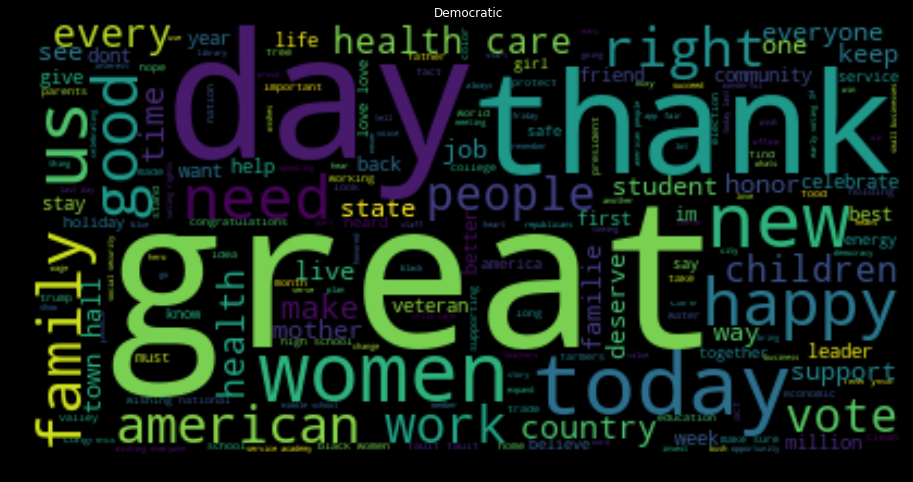

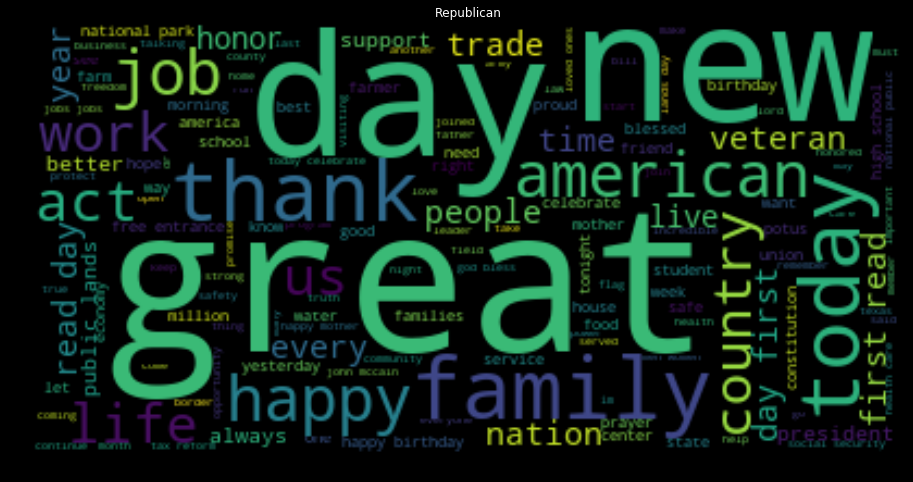

In [34]:
for party, text in positive_clean_text.items():
    drawWordCloud(text, party)

Thsee word clouds look much more similar between the parties than the negatives do.
Some differences include that the Democratic members talk positivly about health care, which is no where to be found in the Republican word cloud.
Republican's have *american*, *country*, and *nation* as large words, which also do appear on the Democratic word clo 
Family is a big thing for both parties.